# Отчет по проекту tg-bots
## Был выпоолнен проект по переносу стиля с одного изображения на другого в форме телеграмм-бота. Использовался код модели из занятия в измененном виде, реализован телеграмм-бот, задеплоен на Heroku, но без webhook и асинхронности.

# Часть 1. Модель для переноса стиля
Код из занятия был изменен. Был реализован класс для сети. 
### В конструкторе:
- определяем последний слой сети из списка заданных слоев
- идем по слоям исходной(VGG16) и добавляем их в нашу сеть
- реализовал с помощью nn.ModuleDict, чтобы потом по имени в forward находить нужный слой
- в это же цикле пропускаем через новые слои тензоры со стилем и контентом, сохраняем результат, а для стиля еще применяем матрицу Грамма.
- заканчиваем, когда доходим до последнего заданного слоя.
Т.о. в конструкторе мы пропустили через сеть стиль и контент, сохранили полученные значения.




In [ ]:
    class Style_transfer(nn.Module):

        #для инициализации задается: обученная сеть(vgg16), нормализация, две картинке в виде тензоров
        #cpu/gpu, списки слоев, на которых берем лоссы, веса стиля и контента
        def __init__(self, cnn, norm_layer, style_img, content_img, device,
                     content_layers, style_layers,
                     style_weight=1_000_000, content_weight=1):
            super().__init__()
            self.style_weight = style_weight
            self.content_weight = content_weight
            self.style_img = style_img
            self.content_img = content_img
            self.content_layers = content_layers
            self.style_layers = style_layers
            self.device = device

            # определяем название последнего слоя сети, чтобы обрезать vgg
            loss_layers = self.content_layers + self.style_layers
            self.last_layer = max(loss_layers)
            cnn = copy.deepcopy(cnn)
            normalization = norm_layer.to(self.device)

            #первый слой - нормализация
            self.layers = nn.ModuleDict({'norm0': normalization})
            self.contents = {}
            self.styles = {}

            i = 0
            #пропускаем стиль и контент через его
            style = self.layers['norm0'](self.style_img)
            content = self.layers['norm0'](self.content_img)

            #идем по слоям исходной сети до последнего заданного
            for layer in cnn.children():
                if isinstance(layer, nn.Conv2d):
                    i += 1
                    name = 'conv_{}'.format(i)
                elif isinstance(layer, nn.ReLU):
                    name = 'relu_{}'.format(i)
                    # Переопределим relu уровень
                    layer = nn.ReLU(inplace=False)
                elif isinstance(layer, nn.MaxPool2d):
                    name = 'pool_{}'.format(i)
                elif isinstance(layer, nn.BatchNorm2d):
                    name = 'bn_{}'.format(i)
                else:
                    raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
                #добавляем слои
                self.layers[name] = layer
                #пропускаем через них стиль и контент
                style = self.layers[name](style).detach()
                content = self.layers[name](content).detach()
                #если слои из списка - сохраняем пропущенные тензоры стиля и контента
                #из стиля считаем матрицу Грамма
                if name in content_layers:
                    self.contents[name] = content
                if name in style_layers:
                    self.styles[name] = self.gram_matrix(style)
                #если дошли до последнего заданного слоя, то сеть готова
                if name == self.last_layer:
                    break

### Прямое распространение - Forward:
- итерируемся по всем слоям сети, пропускаем тензор изменяемого изображения
- если имя слоя входит в наши списки слоев, то результат на выходе из этого слоя считаем соответствующий лосс, используя ранее сохраненные в конструкторе значеня для стиля и контента на этом слое. Для стиля используем матрицу Грамма.
- лоссы для стиля и контента со всех нужных слоев суммируем между собой, а затем сумируем их с заданными весами.
- forward возвращает этот суммарный взвешенный


In [ ]:
        def forward(self, x):
            #будем собирать лоссы по заданным слоям
            content_losses = []
            style_losses = []

            for name, layer in self.layers.items():
                #пропускаем наше изображение
                x = layer(x)
                if name in self.content_layers:
                    # add content loss:
                    content_loss = F.mse_loss(x, self.contents[name])
                    content_losses.append(content_loss)
                if name in self.style_layers:
                    # add style loss:
                    G = self.gram_matrix(x)
                    style_loss = F.mse_loss(G, self.styles[name])
                    style_losses.append(style_loss)

            #сумируем лосы
            style_score = sum(style_losses)
            content_score = sum(content_losses)

            # взвешивание ошибки
            style_score *= self.style_weight
            content_score *= self.content_weight
            loss = style_score + content_score
            #возвращаем сумму взвешенных сум лоссов по заданным слоям
            return loss

### Обучение
- для обучения релизован класс
- в основном методе итерируемся по эпохам, обучаем только исходную картинку
- полсе 200 эпох получаются более-менее интересные рзультаты
В классе также раелизованы методы по преобразованию картинок в тензоры и наоборот.

In [ ]:
 def get_input_optimizer(self, input_img):
        # this line to show that input is a parameter that requires a gradient
        # добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()])
        return optimizer

In [ ]:
    def run_mytransfer(self, content_img, style_img, input_img, num_steps=200,
                       style_weight=1_000_000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')


        model = self.Style_transfer(self.cnn, self.Normalization(self.normalization_mean, self.normalization_std),
                                    style_img, content_img, self.device,
                                    content_layers=self.content_layers_default,
                                    style_layers=self.style_layers_default,
                                    style_weight=style_weight, content_weight=content_weight)
        model.train()
        optimizer = self.get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:
            def closure():
                input_img.data.clamp_(0, 1)
                optimizer.zero_grad()
                loss = model(input_img)
                loss.backward()
                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('loss:{:4f}'.format(loss.item()))
                return loss

            optimizer.step(closure)
        # a last correction...
        input_img.data.clamp_(0, 1)
        return input_img

При малых разрешениях результаты не всегда интересные, вилимо, при сжатии теряюся фичи. При разрешении 512 и 200 эпохах 
получаются хорошие резуьтаты.

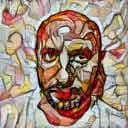 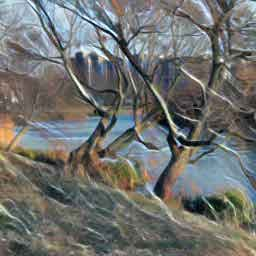

# Часть 2. Телеграмм-бот
Использовал telebot. Работает так:
выводит меню, сначала только ввод изображений, затем вывод нового, настройки и поменять местами стиль и контент.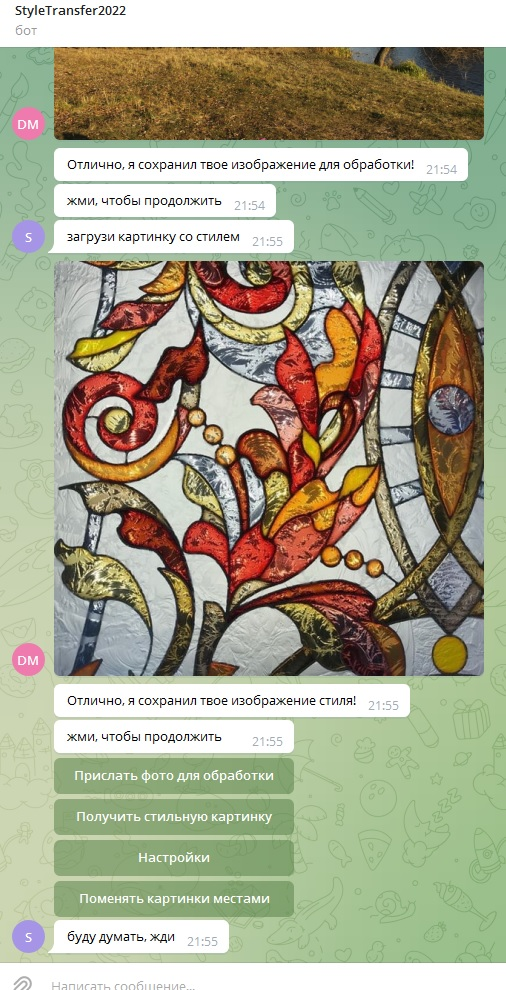


In [ ]:
Сохраняюся оба изображения, можно поменять местами, можно изменить настройки, и снова обработать.
Ниже функция сохранения изображений

In [ ]:
#сохраяняет изображение из сообщения в файл
def save_image_from_message(message):
    global files_counter
    image_id = get_image_id_from_message(message)
    file_path = bot.get_file(image_id).file_path
    image_url = "https://api.telegram.org/file/bot{0}/{1}".format(TOKEN, file_path)
    if not os.path.exists(result_storage_path):
        os.makedirs(result_storage_path)
    image_name = "{0}.jpg".format(image_id)
    urllib.request.urlretrieve(image_url, "{0}/{1}".format(result_storage_path, image_name))
    files_counter +=1
    return image_name

клавиатура вложенная для настроек

In [ ]:
    if where_call == 'start':
        #если последними командами не были загрузка стиля или обмен картинок местами
        if last_instruction[cid] not in ['style', 'swap']:
            #добавляется кнопка "загружаем картинку со стилем"
            key_style = types.InlineKeyboardButton(text='Прислать картинку со стилем', callback_data='style')
            kb.add(key_style)
        # если последними командами не были загрузка контента или обмен картинок местами
        if last_instruction[cid] not in ['content', 'swap']:
            # добавляется кнопка
            key_content = types.InlineKeyboardButton(text='Прислать фото для обработки', callback_data='content')
            kb.add(key_content)
        #если обе картинки загружены - можно запустить алгоритм или настроить, можно местами стиль и контент поменять
        if cid in styleimg_name and cid in contentimg_name:
            if last_instruction[cid] != 'show':
                key_show = types.InlineKeyboardButton(text='Получить стильную картинку', callback_data='show')
                kb.add(key_show)
            if last_instruction[cid] != 'set':
                key_set = types.InlineKeyboardButton(text='Настройки', callback_data='set')
                kb.add(key_set)
            if last_instruction[cid] != 'swap':
                key_swap = types.InlineKeyboardButton(text='Поменять картинки местами', callback_data='swap')
                kb.add(key_swap)
        return kb
    #вложенная клавиатура - что хотим настроить?
    elif where_call == 'options':
        key_res = types.InlineKeyboardButton(text='разрешение картинки на выходе', callback_data='res')
        key_level = types.InlineKeyboardButton(text='насколько стильным должно быть изображение ',
                                               callback_data='level')
        kb.add(key_res)
        kb.add(key_level)
        return kb

обработчик кнопок


In [ ]:
    if call.data == 'style':
        bot.send_message(cid, "загрузи картинку со стилем");
        bot.register_next_step_handler(call.message, get_style)  #запускаем функцию для загрузки
    elif call.data == 'content':
        bot.send_message(cid, "загрузи картинку для обработки");
        bot.register_next_step_handler(call.message, get_content)#запускаем функцию для загрузки
    elif call.data == 'swap':
        bot.send_message(cid, "теперь картинка со стилем и фото поменялись местами");
        swap(call.message)#запускаем функцию для обмена
    elif call.data == 'show':
        bot.send_message(cid, "буду думать, жди");
        showimage(call.message);# запускаем обработку изображения и вывод результата
    #вложенные меню
    elif call.data == 'set':
        bot.edit_message_text(chat_id=cid, message_id=call.message.message_id,
                              text='выбери настройки', reply_markup=keyboard(cid, 'options'))
        close_menu_flag = False
    elif call.data == 'res':
        bot.edit_message_text(chat_id=cid, message_id=call.message.message_id,
                              text=f'выбери разрешение, сейчас {resolution[cid]}',
                              reply_markup=keyboard(cid, 'options_res'))
        close_menu_flag = False
    elif call.data == 'level':
        bot.edit_message_text(chat_id=cid, message_id=call.message.message_id,
                              text=f'выбери уровень, сейчас {"очень" if style_level[cid] == style_levels[1] else "не очень"}',
                              reply_markup=keyboard(cid, 'options_level'))

"насколько стильно" задает вес для лоссов стиля ()

настройки 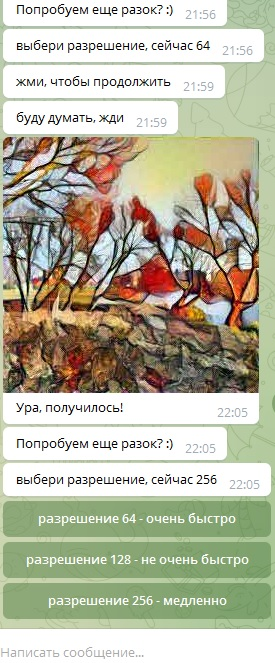    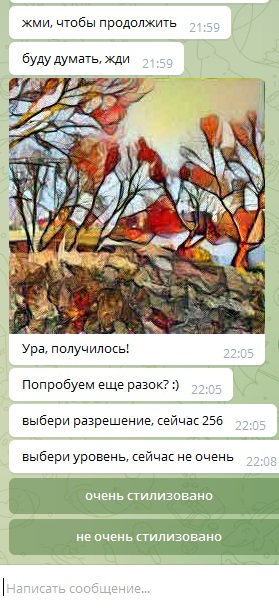

In [ ]:
функция для получения нового изображения
вызывает класс из первой части
выводит изображение

In [ ]:
style_levels = (10_000, 10_000_000)
resolutions = (64, 128, 256)

In [ ]:
def get_image_id_from_message(message):
    return message.photo[len(message.photo) - 1].file_id

#обучение и вывод картинки
def showimage(message):

    cid = message.chat.id
    # запускает обучение, передав два пути к исходным файлам
    output_image = transfer_object('{0}/{1}'.format(result_storage_path, styleimg_name[cid]),
                                    '{0}/{1}'.format(result_storage_path, contentimg_name[cid]),
                                        style_level[cid], resolution[cid])
    # выводит полученный результат
    bot.send_photo(cid, output_image, 'Ура, получилось!')
    bot.send_message(cid, 'Попробуем еще разок? :)')
    # запускает клавиатуру
    bot.send_message(cid, 'жми, чтобы продолжить', reply_markup=keyboard(cid, 'start'))
    # запускает проверку/очистку накопившихся файлов
    clean_images()


бот не асинхронный, без webhook
размещен на heroku
в требованиях был прописан cpu pytorch, чтобы уложится в 500 мегабайт.
Работает бодро, но при размере 512 вылетает. Макисмальный размер генерированного изображения - 256.

In [ ]:
-f https://download.pytorch.org/whl/torch_stable.html
torch==1.8.1+cpu
torchvision==0.9.1+cpu
fastai>=2.3.1
ipywidgets
voila
certifi==2021.10.8
charset-normalizer==2.0.11
idna==3.3
numpy==1.21.5
Pillow==9.0.1
pyTelegramBotAPI==4.4.0
requests==2.27.1
typing-extensions==4.0.1
urllib3==1.26.8


In [ ]:
-----> Building on the Heroku-20 stack
-----> Using buildpack: heroku/python
-----> Python app detected
-----> No Python version was specified. Using the same version as the last build: python-3.9.10
       To use a different version, see: https://devcenter.heroku.com/articles/python-runtimes
-----> No change in requirements detected, installing from cache
-----> Using cached install of python-3.9.10
-----> Installing pip 21.3.1, setuptools 57.5.0 and wheel 0.37.0
-----> Installing SQLite3
-----> Installing requirements with pip
       Looking in links: https://download.pytorch.org/whl/torch_stable.html
-----> Discovering process types
       Procfile declares types -> worker
-----> Compressing...
       Done: 418.9M
-----> Launching...
 !     Warning: Your slug size (418 MB) exceeds our soft limit (300 MB) which may affect boot time.
       Released v8
       https://styletransfer2022.herokuapp.com/ deployed to Heroku

### Результат:
переделан код из занятия, реализован соответствующий класс и размещен в отдельном модуле.
написан бот, с меню, настройками изображения.
деплой  на heroku.
Выдает интересные результаты.
### НЕ выполнено:
Не хватает памяти на heroku, чтобы разрешение 512 реализовать.
Не оптимально написаны обработчики и логика бота.
Не реализован  webhook вместо polling, асинхорнность.

In [ ]:
github

https://github.com/dmitry-i-k/DLS1_project_tg-bots

Телеграмм бота
@StyleTransfer2022_bot

StyleTransfer2022

Мой номер:
+375295757018

телеграмм, вайбер в любое время

dzmitry.khatsuk@gmail.com


